# Titanic

In [33]:
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import skew
from math import sqrt
from IPython.display import display

In [34]:
DATA_PATH = "data/"

In [35]:
os.listdir(DATA_PATH)

['data.csv', 'gender_submission.csv', 'test.csv', 'train.csv']

## Chargement des données

In [36]:
df_train_raw = pd.read_csv(f"{DATA_PATH}train.csv")

In [37]:
df_train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Pclass - classe dans laquel les passagers sont <br>
SibSp - présence de frères ou de soeurs sur le bateau<br>
Parch - précence des parents<br>
Ticket - numéro du ticket (qui peut être commun à plusieurs passagers)<br>
Fare - prix du ticket<br>
Cabin - numéro de cabine, si une cabine est comprise<br>
Embarked - port d'embarquement (Southampton, Cherbourg ou Queenstown)<br>

## Netoyage des données

In [38]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        Inputs:
            df: dataframe to analyze
            keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        Outputs:
            res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [39]:
missing_values_stats(df_train_raw)

,Total,Percentage
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


### Embarked

In [40]:
df_train_raw[df_train_raw['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [41]:
# on regarde toutes les personnes présente sur le ticket
df_train_raw[df_train_raw['Ticket'] == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


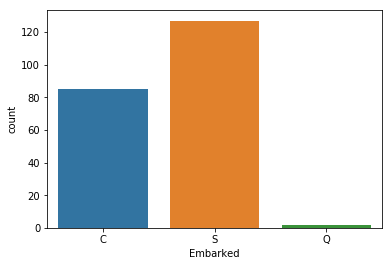

In [42]:
# On regarde nombre de passagers en classe 1 pour chaque port
sns.countplot(df_train_raw.loc[df_train_raw['Pclass'] == 1, 'Embarked'].dropna())

In [43]:
df_train_raw.loc[df_train_raw['Embarked'].isna(), 'Embarked'] = 'S'

### Age 

/home/vialla/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


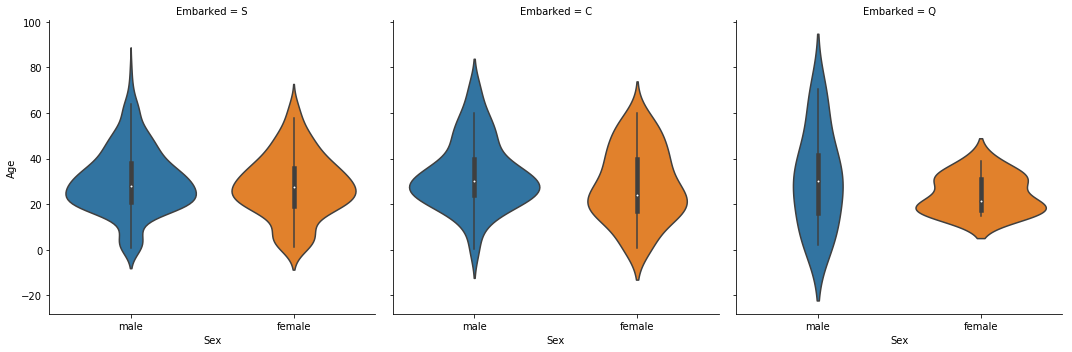

In [44]:
sns.factorplot(x="Sex", y="Age", col="Embarked", data=df_train_raw[df_train_raw['Age'].isna() == False], kind="violin")

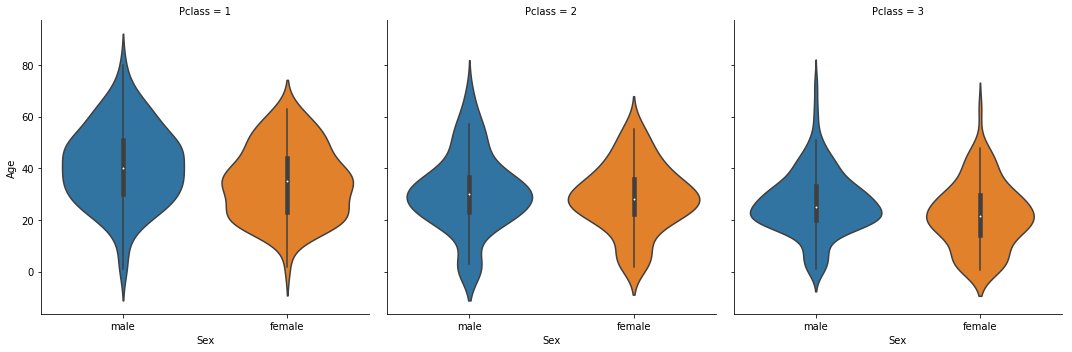

In [45]:
sns.factorplot(x="Sex", y="Age", col="Pclass", data=df_train_raw[df_train_raw['Age'].isna() == False], kind="violin")

In [46]:
df_train_raw['Sex'] = df_train_raw['Sex'].astype('category')
df_train_raw['Embarked'] = df_train_raw['Embarked'].astype('category')
for s in df_train_raw["Sex"].cat.categories:
    for e in df_train_raw["Embarked"].cat.categories:
        mean = df_train_raw[(df_train_raw.Sex == s) & (df_train_raw.Embarked == e)]["Age"].dropna().mean()
        std = df_train_raw[(df_train_raw.Sex == s) & (df_train_raw.Embarked == e)]["Age"].dropna().std()
        size = df_train_raw[(df_train_raw.Sex == s) & (df_train_raw.Embarked == e)]["Age"].isna().sum()
        df_train_raw.loc[(df_train_raw.Sex == s) & (df_train_raw.Embarked == e) & (df_train_raw.Age.isna()), "Age"] = np.random.normal(mean, std, size)

In [47]:
df_train_raw.drop(df_train_raw.loc[df_train_raw.Age < 0].index, axis=0, inplace=True)

### Cabin

In [48]:
df_train_raw.drop('Cabin', axis=1, inplace=True)

## Etude des variables

### is_alone ?

In [58]:
df = df_train_raw
df.reset_index(inplace=True, drop=True)

In [59]:
df['Ticket'] = df['Ticket'].astype('category')

In [60]:
res = []
for i in range(0, len(df)):
    ticket = df.loc[i, 'Ticket']
    res.append(len(df[df['Ticket'] == ticket]))

In [61]:
df['PassengerPerTicket'] = res

In [62]:
df['isAlone'] = ((df['PassengerPerTicket'] + df['SibSp'] + df['Parch']) == 1)

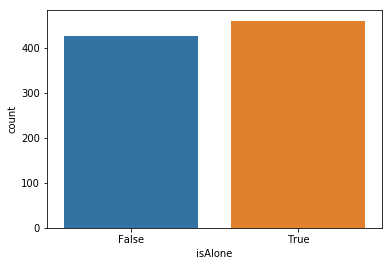

In [63]:
sns.countplot(df['isAlone'])

In [64]:
df.loc[df['Sex'] == 'male', 'isAlone'].value_counts()

True     365
False    209
Name: isAlone, dtype: int64

In [65]:
df.loc[df['Sex'] == 'female', 'isAlone'].value_counts()

False    218
True      95
Name: isAlone, dtype: int64

### Taille groupe de voyage

In [66]:
res = []
for i in range(0, len(df)):
    family_name = df.loc[i, "Name"].split(",")[0]
    ticket = df.loc[i, "Ticket"]
    tmp = df[df.Ticket == ticket]
    res.append((tmp["Name"].apply(lambda x: x.split(",")[0]) != family_name).sum())

In [67]:
df["GroupSize"] = df["SibSp"] + df["Parch"] + res

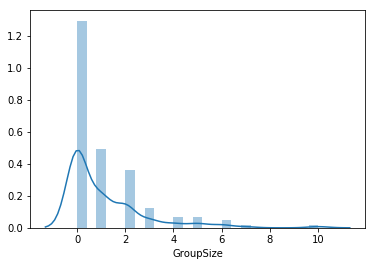

In [68]:
sns.distplot(df["GroupSize"])

In [69]:
df_train = df[df['Survived'].isna() == False]

## Création du modèle 
Ici on créer un modèle

In [70]:
df_train = df_train.join(pd.get_dummies(df_train['Embarked'], prefix='Embarked'))

In [71]:
df_train['Sex'] = df_train['Sex'].astype('category')

In [72]:
df_train['Sex'] = df_train['Sex'].cat.codes

### Forêt aléatoire

In [80]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)

In [81]:
df_train = df_train.sample(frac=1)

In [82]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'PassengerPerTicket', 'isAlone',
       'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [83]:
clf.fit(df_train[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_train['Survived'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [84]:
clf.oob_score_

0.7959413754227734

### Regression linéaire

In [86]:
clf_lin = LinearRegression().fit(df_train[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_train['Survived'])

In [87]:
clf_lin.score(df_train[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_train['Survived'])

0.3994140702452177

## Matrice de corrélation

http://tylervigen.com/spurious-correlations

In [88]:
corrmat = df_train[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']].corr()

In [89]:
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [90]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

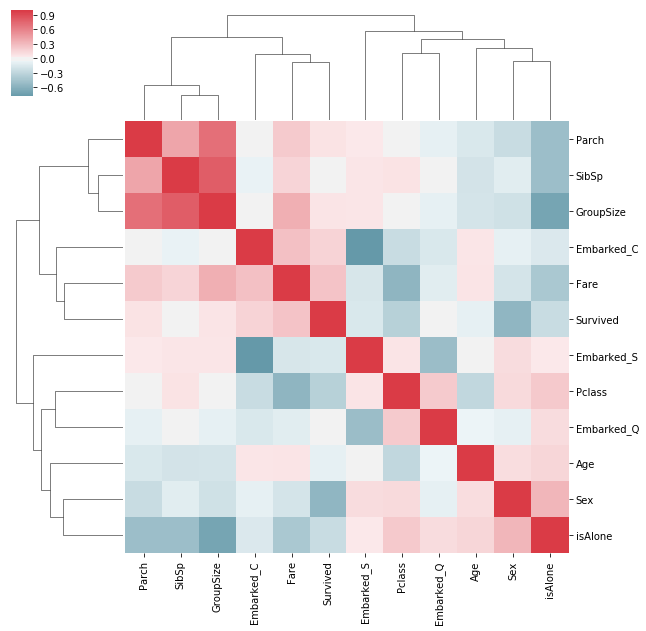

In [91]:
sns.clustermap(corrmat, cmap=cmap, center=0,
            xticklabels=corrmat.columns.values,
            yticklabels=corrmat.columns.values)

In [92]:
def corr_mat_feat(df, feat, k_pos=5, k_neg=5, corrmat=None, cmap=None):
    if corrmat is None:
        corrmat = df.corr()
    if cmap is None:
        cmap = cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cols = list(corrmat.nlargest(k_pos, feat)[feat].index) + list(corrmat.nsmallest(k_neg, feat)[feat].index)
    cols = list(set(cols))
    cols_labels = cols
    cm = df[cols].corr()
    sns.clustermap(cm, cbar=True, annot=True, square=True, cmap=cmap, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_labels, xticklabels=cols_labels, center=0)

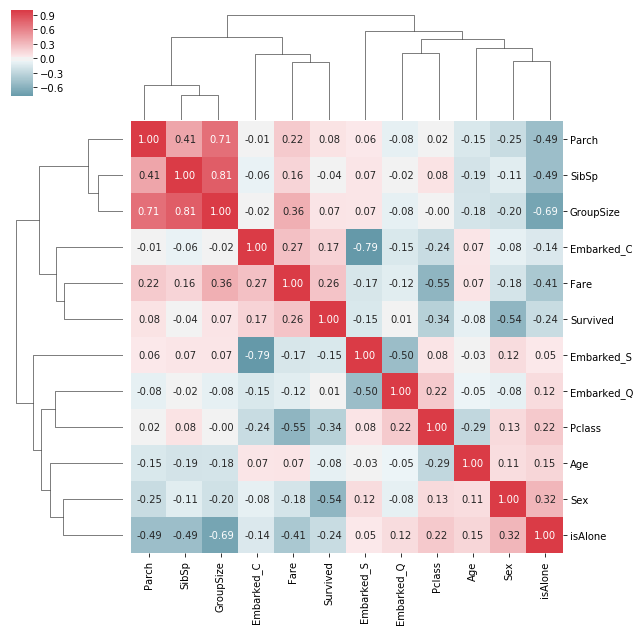

In [93]:
corr_mat_feat(df_train[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']], "Survived", k_pos=10, k_neg=7, corrmat=corrmat)

In [96]:
# Sexe des personnes ayant survécues
len(df_train.loc[df_train['Sex'] == 0, 'Survived']), len(df_train.loc[df_train['Sex'] == 1, 'Survived'])

(313, 574)

In [97]:
# Femmes ayant survécues par rapport aux mortes
len(df_train.loc[(df_train['Sex'] == 0) & (df_train['Survived'] == 1)]), len(df_train.loc[(df_train['Sex'] == 0) & (df_train['Survived'] == 0)])

(233, 80)

In [98]:
# Hommes ayant survécus par rapport aux mortes
len(df_train.loc[(df_train['Sex'] == 1) & (df_train['Survived'] == 1)]), len(df_train.loc[(df_train['Sex'] == 1) & (df_train['Survived'] == 0)])

(109, 465)

Avis ?

## Analyse de l'importance des variables du modèle

In [55]:
def get_features_importance(model, df):
    return pd.DataFrame({"cols": df.columns, "imp": model.feature_importances_}).sort_values("imp", ascending=False)
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

In [68]:
feat_importance = get_features_importance(clf, df_train[['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']])

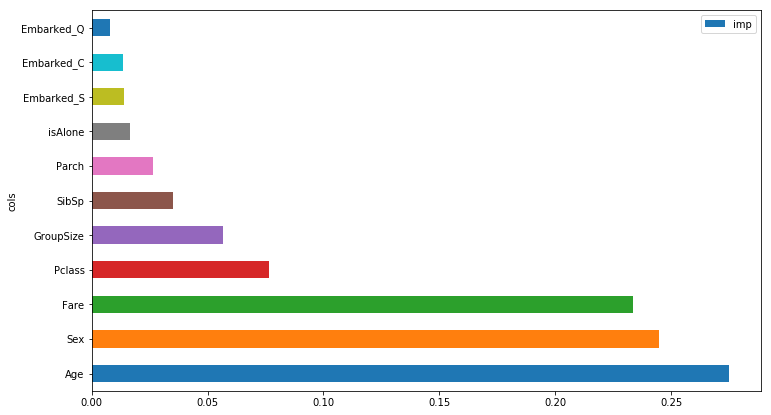

In [69]:
plot_feat_importance(feat_importance[:30])

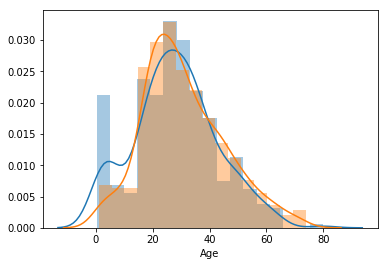

In [70]:
sns.distplot(df_train.loc[df_train['Survived'] == 1, 'Age'])
sns.distplot(df_train.loc[df_train['Survived'] == 0, 'Age'])

## Analyse détaillée du modèle : graphes de dépences partielles

In [100]:
from pdpbox import pdp, get_dataset, info_plots

In [101]:
keep_feats = ['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

### Sex

In [102]:
test_titanic = get_dataset.titanic()

In [103]:
titanic_data = df_train
titanic_features = ['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'isAlone', 'GroupSize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
titanic_model = clf
titanic_target = 'Survived'

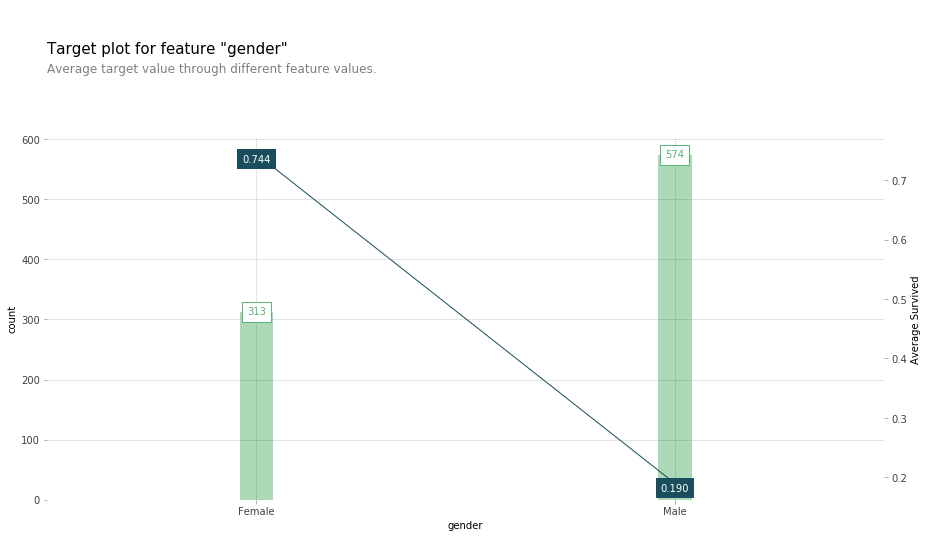

In [104]:
fig, axes, summary_df = info_plots.target_plot(df=titanic_data, feature='Sex', feature_name='gender', target=titanic_target)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

In [105]:
summary_df

,x,display_column,count,Survived
0,0,Sex_0,313,0.744409
1,1,Sex_1,574,0.189895


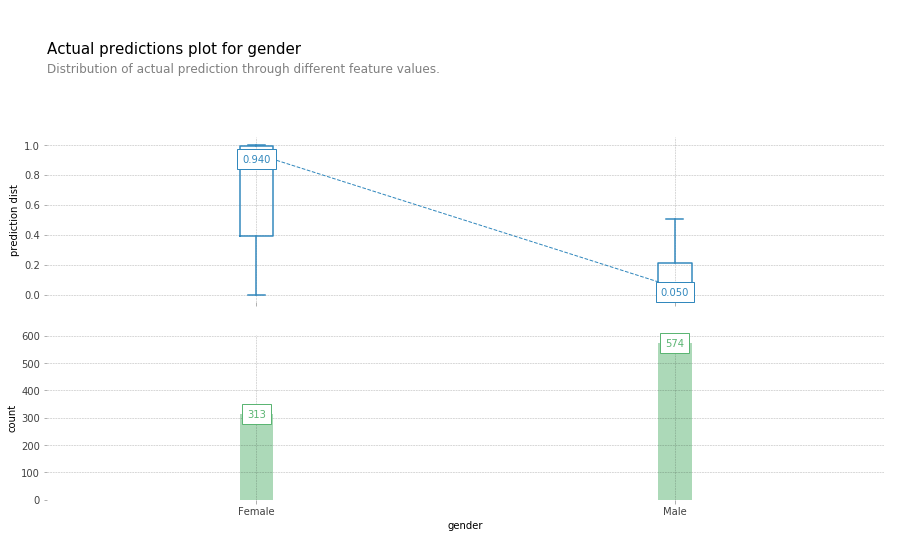

In [107]:
fig, axes, summary_df = info_plots.actual_plot(model=titanic_model, X=titanic_data[titanic_features], feature='Sex', feature_name='gender', predict_kwds = {})
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

In [108]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,Sex_0,313,0.390000,0.94,0.99
1,1,Sex_1,574,0.006667,0.05,0.21


In [109]:
pdp_sex = pdp.pdp_isolate(model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature='Sex')

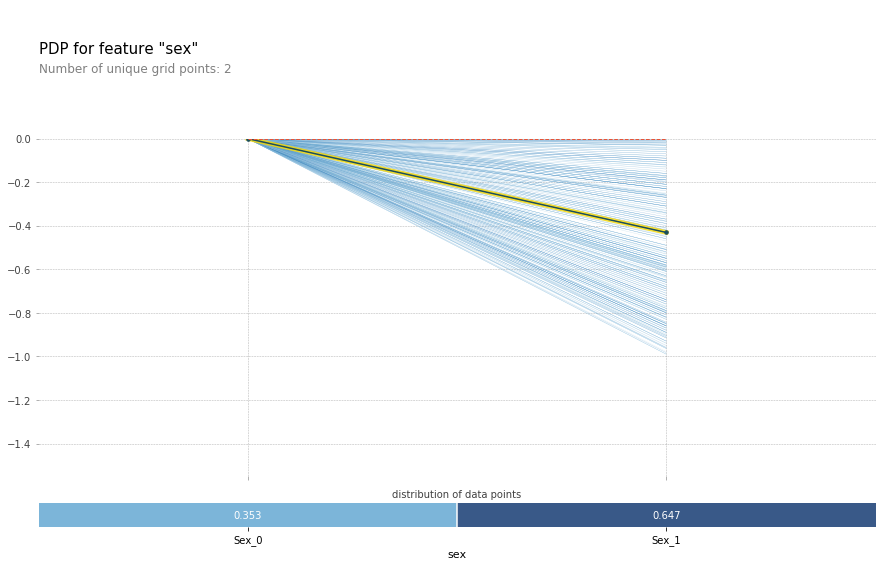

In [112]:
fig, axes = pdp.pdp_plot(pdp_sex, 'sex', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

## Port d'embarquement

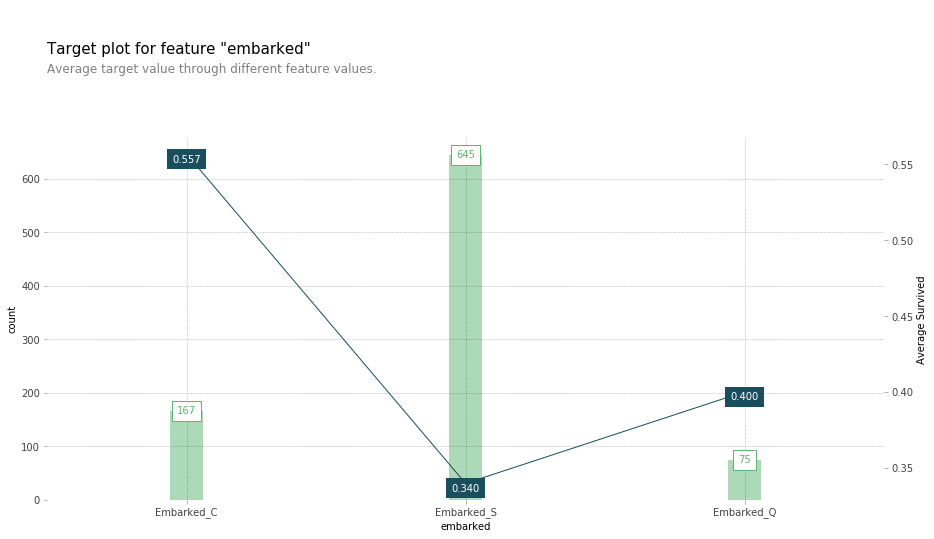

In [113]:
fig, axes, summary_df = info_plots.target_plot(df=titanic_data, feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], feature_name='embarked', target=titanic_target)

In [114]:
summary_df

,x,display_column,count,Survived
0,0,Embarked_C,167,0.556886
1,1,Embarked_S,645,0.339535
2,2,Embarked_Q,75,0.400000


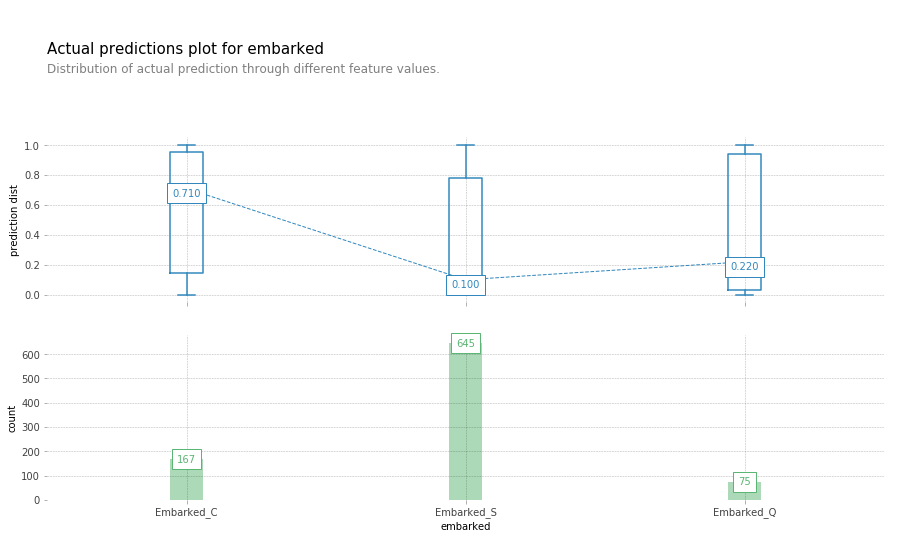

In [115]:
fig, axes, summary_df = info_plots.actual_plot(model=titanic_model, X=titanic_data[titanic_features], feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], feature_name='embarked', predict_kwds = {})

In [116]:
pdp_embark = pdp.pdp_isolate(model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'])

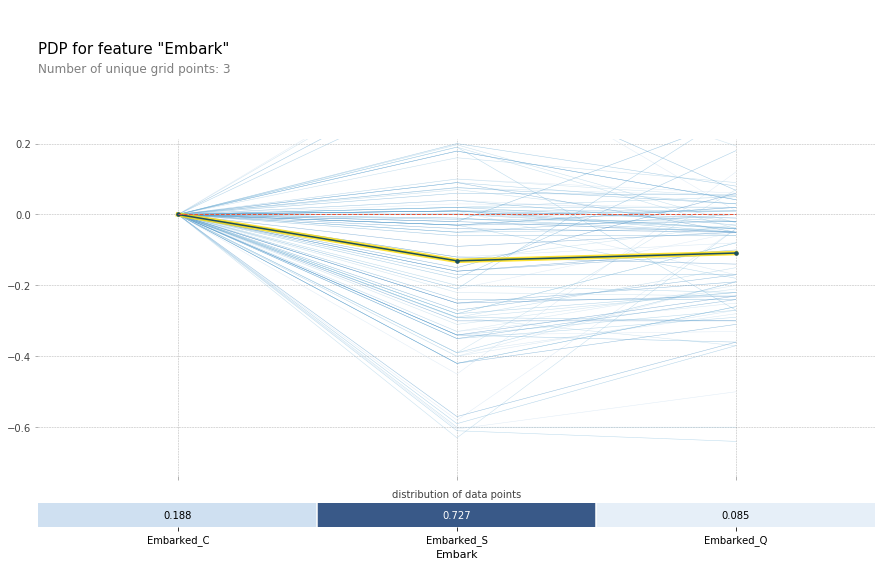

In [117]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

## Prix du ticket

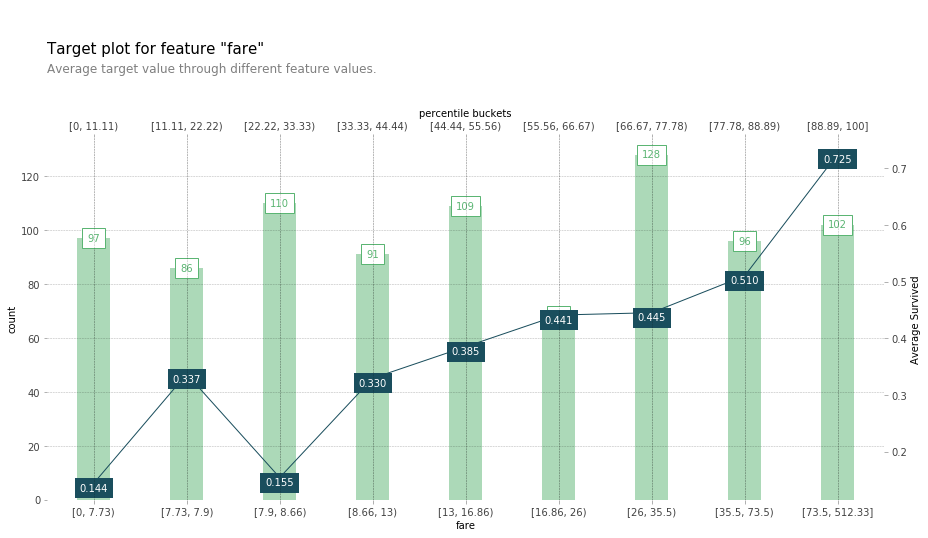

In [118]:
fig, axes, summary_df = info_plots.target_plot(df=titanic_data, feature='Fare', feature_name='fare', target=titanic_target, show_percentile=True)

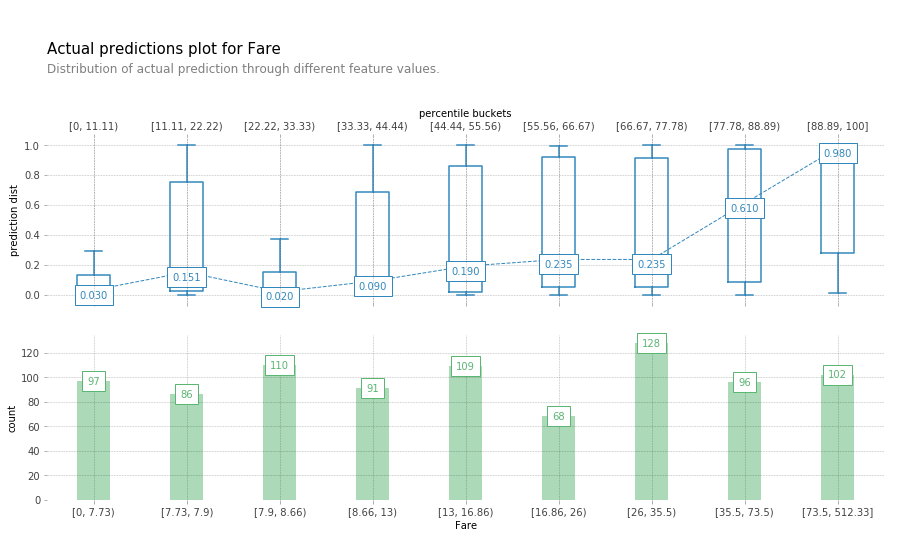

In [119]:
fig, axes, summary_df = info_plots.actual_plot(model=titanic_model, X=titanic_data[titanic_features], feature='Fare', feature_name='Fare', show_percentile=True, predict_kwds={})

In [120]:
pdp_fare = pdp.pdp_isolate(model=titanic_model, dataset=titanic_data, model_features=titanic_features, feature='Fare')

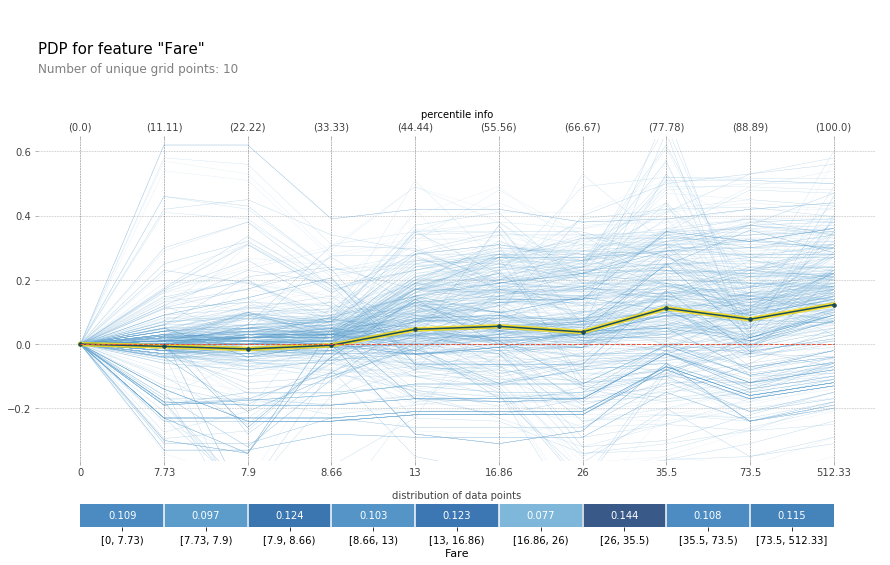

In [121]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True)

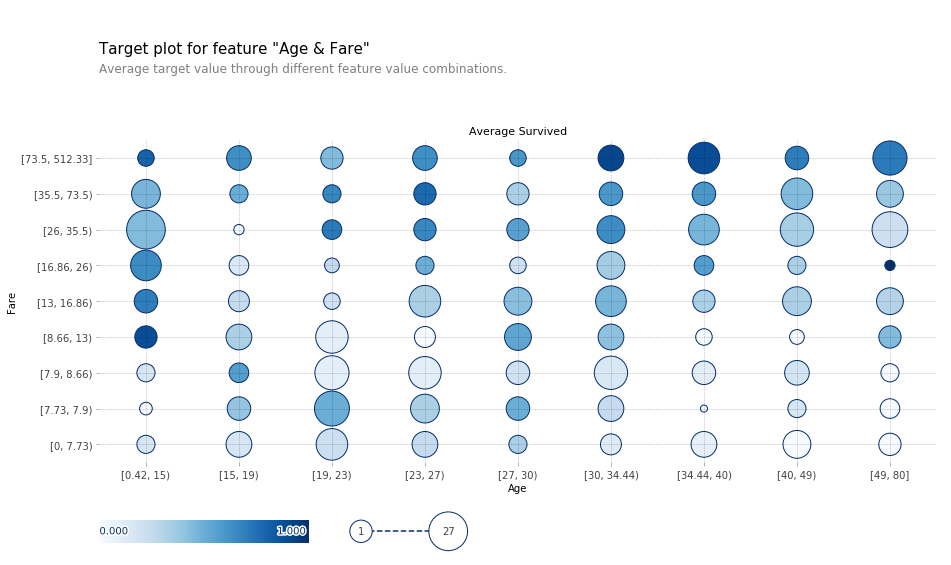

In [122]:
fig, axes, summary_df = info_plots.target_plot_interact(df=titanic_data, features=['Age', 'Fare'], feature_names=['Age', 'Fare'], target=titanic_target)

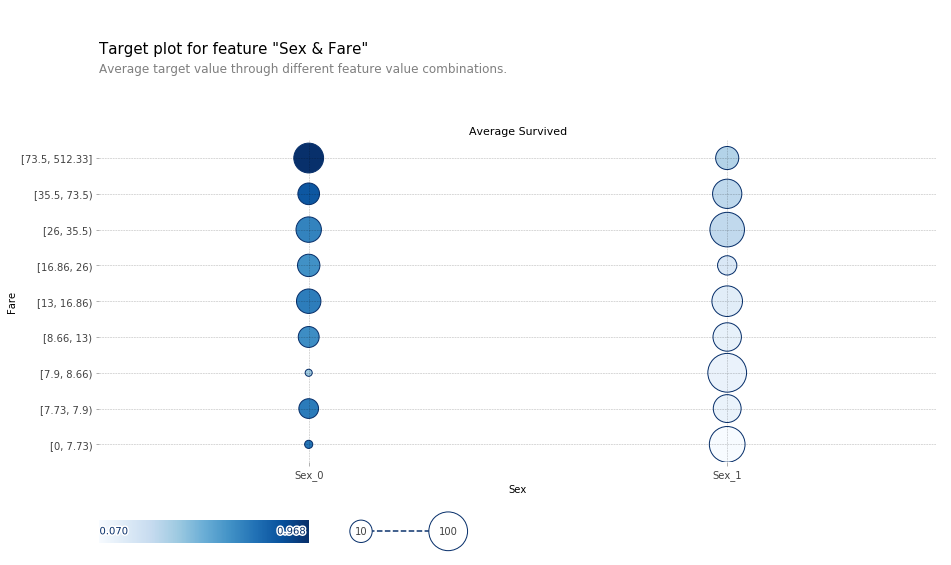

In [123]:
fig, axes, summary_df = info_plots.target_plot_interact(df=titanic_data, features=['Sex', 'Fare'], feature_names=['Sex', 'Fare'], target=titanic_target)

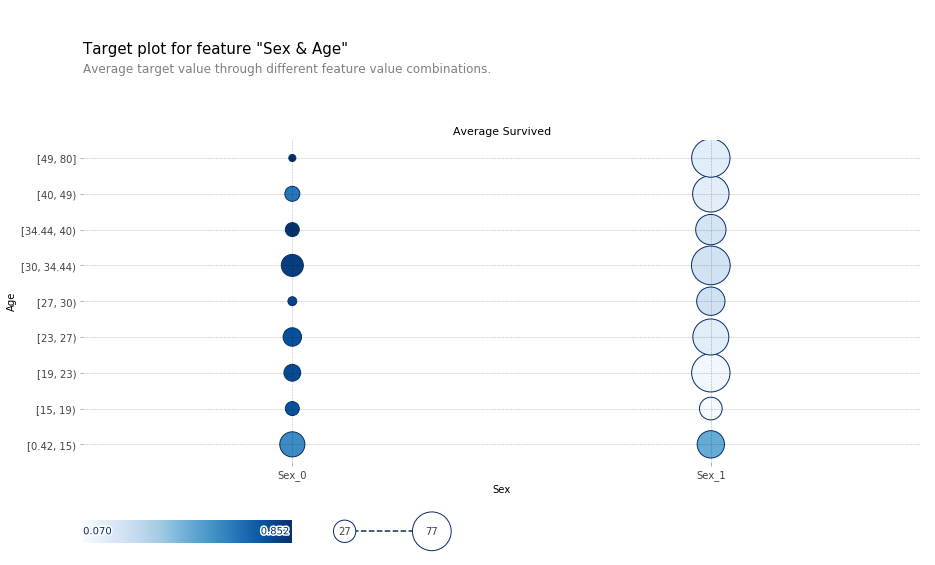

In [124]:
fig, axes, summary_df = info_plots.target_plot_interact(df=titanic_data, features=['Sex', 'Age'], feature_names=['Sex', 'Age'], target=titanic_target)

In [125]:
inter1 = pdp.pdp_interact(model=titanic_model, dataset=titanic_data, model_features=titanic_features, features=['Age', 'Fare'])

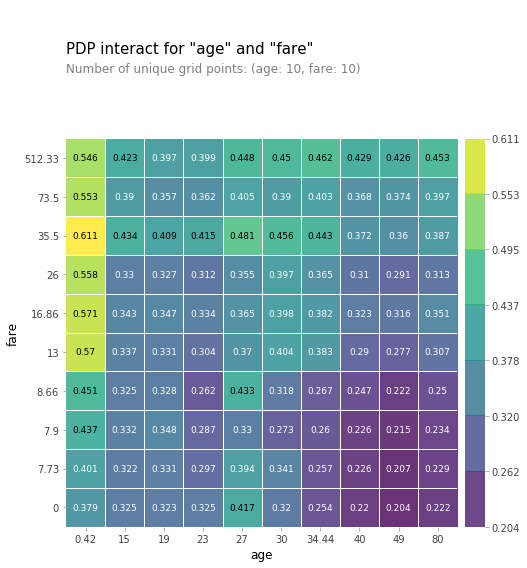

In [126]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='grid', x_quantile=True, plot_pdp=False)